## Bayesian Linear Regression

Consider the Bayesian linear regression model with
$$p(y\mid x,w) = \mathcal{N}(y\mid w^{T}\phi(x),\alpha^{-1}I), \ p(w)=\mathcal{N}(w\mid 0,\beta^{-1}I),$$

with $\alpha = 0.5, \beta  = 0.1$. Generate a set of $N = 400$ noisy observations by uniformly sampling

$$y(x) = \sin(\pi x) + \sin(2 \pi x) + \sin(5 \pi x)\quad x\in[-1,1]$$

Once you've created the observations, perturb the data with a normal distribution with standard deviation set to 10% of the data. Compute the MLE and MAP estimates for the weights $w$ using different types and numbers of features $\phi(x)$:
- Monomial basis: $\phi(x) = \{1, x, x^2, x^3, \dots, x^M\}$
- Fourier basis: $\phi(x) = \{0, 1, \sin(\pi x), \cos(\pi x), \sin(2\pi x), \cos(2\pi x), \dots, \sin(M\pi x), \cos(M\pi x)\}$ (this case has a total of $2M$ features)
- [Legendre](https://en.wikipedia.org/wiki/Legendre_polynomials) basis: $\{P_0(x), P_1(x), P_2(x), P_3(x), \dots, P_M(x)\}$, where $P_0(x) = 1, P_1(x) = x$, and subsequent polynomials can be generated by the recursion $(n + 1) P_{n+1} (x) = (2n + 1) x P_n(x) - n P_{n - 1}(x).$

For the case $M=5$, plot the data, the mean predictions corresponding to the MLE and MAP estimates for $w$, and $100$ samples from the predictive posterior distribution.
Which set of features works best for this function and why?

1. Fourier basis fits better than the other two basis. It is because the y's are generated from x using to sine and cosine function, as the Fourier basis uses sine and cosine funtions, we can expect it to fit the given dataset well.

In [ ]:
!pip install --upgrade pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=6522db0006a2deef497e01d2ab2dba135aea4300d24964c8018eabae33cdfaf1
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


In [ ]:
import numpy as np
from numpy import pi
import jax.numpy as jnp   
from jax import grad, jacfwd, jit, random, vmap
from jax.scipy.stats import multivariate_normal
from jax.tree_util import tree_map
from numpy.matrixlib import mat
from jax._src.numpy.ufuncs import square
from IPython.display import clear_output
import matplotlib.pyplot as pl
from matplotlib import style
from jax.scipy.stats import norm
#style.use('dark_background')
from pyDOE import lhs

In [ ]:
#___________________|PART-1|__________________
#Given:
alpha =  0.5
beta = 0.1
b_a = 0.2
N = 400
#Set a key:
key = random.PRNGKey(0)

#Generate 400 samples of x:
x = random.uniform(key, (N, 1) , minval=-1.0, maxval=1.0)

#Calculate y using the relation given:
y_uniform = jnp.sin(pi*x)+jnp.sin(2*pi*x)+jnp.sin(5*pi*x)

#Calculate standard deviation of y:
std_y = jnp.std(y_uniform)

#Purturbing data:
k1 = random.PRNGKey(1)

# Generate 400 samples normally distributed for noise:
purturb = 0.1 * std_y * random.normal(k1, (N,1))

#Values of purturbed y:
y = y_uniform + purturb

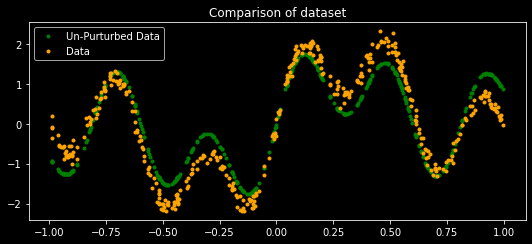

In [ ]:
pl.rcParams["figure.figsize"] = [7.50, 3.50]
pl.rcParams["figure.autolayout"] = True

def f(x):
    return np.sin(x)+np.sin(2*pi*x)+np.sin(5*pi*x)

pl.plot(x, f(x), '.', label = 'Un-Purturbed Data', color='green' )
pl.plot(x, y, '.', label = 'Data', color = 'orange')
pl.title('Comparison of dataset')
pl.legend()
pl.show()

In [ ]:
#_____________________PART-2.1_______________________
#Define the basis function:
#1. Polynomial basis
def poly_phi_x(x):
  pw = jnp.ones((6,))
  pw0 = 1
  pw1 = x[0]**1
  pw2 = x[0]**2
  pw3 = x[0]**3
  pw4 = x[0]**4
  pw5 = x[0]**5
  pw = pw.at[0].set(pw0)
  pw = pw.at[1].set(pw1)
  pw = pw.at[2].set(pw2)
  pw = pw.at[3].set(pw3)
  pw = pw.at[4].set(pw4)
  pw = pw.at[5].set(pw5)
  return pw

vec_poly_phi_x = vmap(poly_phi_x, in_axes=(0))

#_________________MLE_______________
X = vec_poly_phi_x(x)
#print(X.shape)
XT = X.T
#print(XT.shape)
X_inv = np.linalg.inv(jnp.matmul(XT, X))
w_MLE = jnp.matmul(jnp.matmul(X_inv, XT), y)
#print(w_MLE)
#_________________MAP__________________

l_inv = np.linalg.inv(jnp.matmul(XT, X) + b_a*jnp.eye(6,6))
print(l_inv.shape)
w_MAP = jnp.matmul(jnp.matmul(l_inv, XT), y)
#print(w_MAP)


(2, 400)
(2400,)
(400,)
(400,)


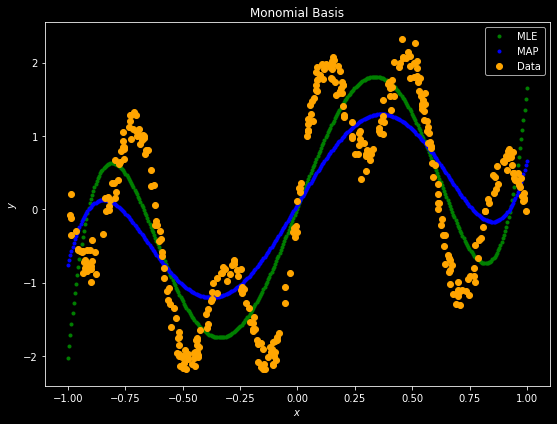

In [ ]:
# Predict at a set of test points
x_star = np.linspace(-1, 1, 400)[:,None]
X_star = vec_poly_phi_x(x_star)
Y_pred_MLE = X_star @ w_MLE
Y_pred_MAP = X_star @ w_MAP

mean_star = X_star @ w_MAP
var_star = 1/alpha + (X_star @ l_inv) @ X_star.T
key3 = random.PRNGKey(3)

num_samples = 100
samples = random.multivariate_normal(key, mean_star.flatten(), var_star, (num_samples,))
percentiles = np.percentile(samples, np.array([5.0, 95.0]), axis=0)
print(percentiles.shape)

print(X_star.flatten().shape)
print(percentiles[0, :].shape)
print(percentiles[1, :].shape)

plt.figure(1, figsize=(15, 6))
pl.subplot(1,2,1)
pl.plot(x_star, Y_pred_MLE, '.', label = 'MLE', color = 'green')
pl.plot(x_star, Y_pred_MAP, '.', label = 'MAP', color = 'blue')
pl.plot(x, y,'o', label = 'Data', color = 'orange')
plt.fill_between(x_star.flatten(), percentiles[0, :], percentiles[1, :], color='white')
pl.xlabel('$x$')
pl.ylabel('$y$')
pl.tight_layout()
pl.legend()
pl.title('Monomial Basis')
pl.show()



In [ ]:
#_____________________PART-2.2_______________________
#Define the basis function:
#2. Fourier Basis:
def F_phi_x(x):
  f = jnp.ones((12,))
  
  f0 = 0
  f1 = 1
  f2 = jnp.sin(pi*x[0])
  f3 = jnp.cos(pi*x[0])
  f4 = jnp.sin(2*pi*x[0])
  f5 = jnp.cos(2*pi*x[0])
  f6 = jnp.sin(3*pi*x[0])
  f7 = jnp.cos(3*pi*x[0])
  f8 = jnp.sin(4*pi*x[0])
  f9 = jnp.cos(4*pi*x[0])
  f10 = jnp.sin(5*pi*x[0])
  f11 = jnp.cos(6*pi*x[0])

  f = f.at[0].set(f0)
  f = f.at[1].set(f1)
  f = f.at[2].set(f2)
  f = f.at[3].set(f3)
  f = f.at[4].set(f4)
  f = f.at[5].set(f5)
  f = f.at[6].set(f6)
  f = f.at[7].set(f7)
  f = f.at[8].set(f8)
  f = f.at[9].set(f9)
  f = f.at[10].set(f10)
  f = f.at[11].set(f11)

  return f

vec_F_phi_x = vmap(F_phi_x, in_axes=(0))

#_________________MLE_______________
X = vec_F_phi_x(x)
#print(X.shape)
X_inv = np.linalg.pinv(X)
w_MLE = jnp.matmul(X_inv, y)

#_________________MAP__________________
XT = X.T
l_inv = np.linalg.inv(jnp.matmul(XT, X) + b_a*jnp.eye(12,12))
w_MAP = jnp.matmul(jnp.matmul(l_inv, XT), y)

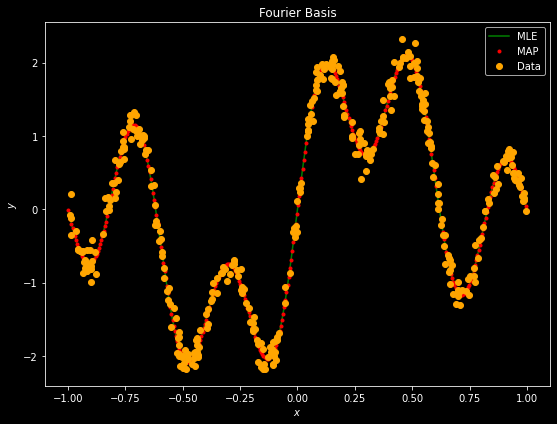

In [ ]:
#Plotting Output
# Predict at a set of test points
x_star = np.linspace(-1, 1, 400)[:,None]
X_star = vec_F_phi_x(x_star)

Y_pred_MLE = X_star @ w_MLE
Y_pred_MAP = X_star @ w_MAP

plt.figure(1, figsize=(15, 6))
pl.subplot(1,2,1)
pl.plot(x_star, Y_pred_MLE, '-', label = 'MLE', color = 'green')
pl.plot(x_star, Y_pred_MAP, '.', label = 'MAP', color='red')
plt.plot(x, y,'o', label = 'Data', color = 'orange')
#plt.fill_between(X_star.flatten(), percentiles[0, :], percentiles[1, :], color='lightblue')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()
pl.legend()
pl.title('Fourier Basis')
pl.show()

In [ ]:
#_____________________PART-2.3_______________________
#Define the basis function:
#3. Legendre Basis:
def L_phi_x(x):
  l = jnp.ones((6,))
  
  l0 = 1
  l1 = x[0]
  l2 = 3*x[0]**2 - 1
  l3 = 15*x[0]**3 - 7*x[0]
  l4 = 105*x[0]**4 - 58*x[0]**2 + 3
  l5 = 945*x[0]**5 - 582*x[0]**3 - 55*x[0]
  
  l = l.at[0].set(l0)
  l = l.at[1].set(l1)
  l = l.at[2].set(l2)
  l = l.at[3].set(l3)
  l = l.at[4].set(l4)
  l = l.at[5].set(l5)

  return l

vec_L_phi_x = vmap(L_phi_x, in_axes=(0))

#_________________MLE_______________
X = vec_L_phi_x(x)
X_inv = np.linalg.pinv(X)
w_MLE = jnp.matmul(X_inv, y)
#_________________MAP__________________
XT = X.T
l_inv = np.linalg.inv(jnp.matmul(XT, X) + b_a*jnp.eye(6,6))
w_MAP = jnp.matmul(jnp.matmul(l_inv, XT), y)

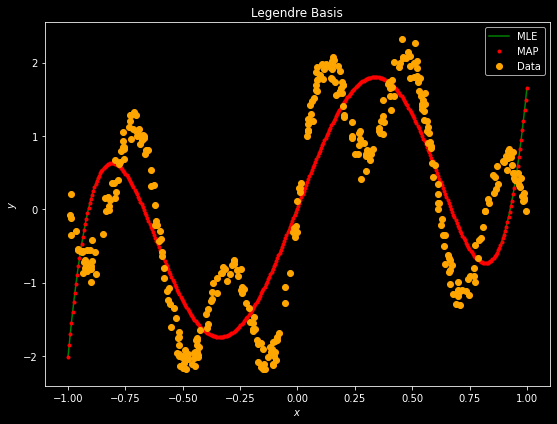

In [ ]:
#Plotting Output
# Predict at a set of test points
x_star = np.linspace(-1, 1, 400)[:,None]
X_star = vec_L_phi_x(x_star)

Y_pred_MLE = X_star @ w_MLE
Y_pred_MAP = X_star @ w_MAP

plt.figure(1, figsize=(15, 6))
pl.subplot(1,2,1)
pl.plot(x_star, Y_pred_MLE, '-', label = 'MLE', color = 'green')
pl.plot(x_star, Y_pred_MAP, '.', label = 'MAP', color='red')
plt.plot(x, y,'o', label = 'Data', color = 'orange')
#plt.fill_between(X_star.flatten(), percentiles[0, :], percentiles[1, :], color='lightblue')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.tight_layout()
pl.legend()
pl.title('Legendre Basis')
pl.show()